In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import sys
sys.path.append("..")
import data_loader

In [2]:
def format_oxidation(row, column, to_replace):
    peptide = row[column]
#     print(to_replace)
    replace_with = "+15.995"
    if pd.isna(peptide):
        new_pep = peptide
    else:
        if to_replace in peptide:
            new_pep = peptide.replace(to_replace, replace_with)
        else:
            new_pep = peptide
    return new_pep

def format_carbamidomethyl(row, column, to_replace):
    peptide = row[column]
#     print(to_replace)
    replace_with = ""
    if pd.isna(peptide):
        new_pep = peptide
    else:
        if to_replace in peptide:
            new_pep = peptide.replace(to_replace, replace_with)
        else:
            new_pep = peptide
    return new_pep


In [3]:
def clean_MM(input_file):
    data = pd.read_csv(input_file, sep = '\t')

    #make a new col that includes modifide peptides
    data['temp_peptide'] = data.apply(lambda row: format_oxidation(row, "Full Sequence", "[Common Variable:Oxidation on M]"), axis=1)
    data["temp2"] = data.apply(lambda row: format_carbamidomethyl(row, "temp_peptide", "[Common Fixed:Carbamidomethyl on C]"), axis=1)

    data = data.replace({"Decoy": {'Y': True, 'N': False}})
    #uniform naming
    data_new = data.rename({"Decoy": "decoy", "Scan Number": "scan", "temp2": "peptide", 'PEP_QValue': 'probability'}, axis=1)
    data_new = data_new.filter((['decoy', 'scan', 'peptide','probability', 
                                 "Matched Ion Series", 'Matched Ion Intensities', 'Matched Ion Counts', 'Matched Ion Mass Diff (Ppm)']))

    return data_new


In [4]:
def filter_data(df, SC):
    df = df[df["decoy"]==False]
    df = df.sort_values("probability")
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    df = df.sort_values("probability")
    df = df.drop_duplicates(subset=["peptide"], keep="first")#I only want unique peptides 
    if SC==True: 
        df = df[(df["probability"] <= .01)]
    else:
        df = df[df["probability"] <= .01]
    return df


In [5]:
small = clean_MM("~/Payne/bulk_data_vs_2ng/Ex_Auto_DrM3_30umT4_2ngQC_60m_half_PSMs.psmtsv.gz")
large = clean_MM("~/Payne/bulk_data_vs_2ng/metamorpheus_output/AllPSMs2.psmtsv")

small = filter_data(small, SC=True)
large = filter_data(large, SC=False)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (11,19,20,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
small.tail()

,decoy,scan,peptide,probability,Matched Ion Series,Matched Ion Intensities,Matched Ion Counts,Matched Ion Mass Diff (Ppm)
14488,False,16175,FDGVQDPR,0.009731,"[b2+1, b3+1];[y1+1, y2+1, y4+1, y6+1, y7+1]","[b2+1:1685, b3+1:1912];[y1+1:4175, y2+1:15665,...",7,"[b2+1:3.25, b3+1:5.79];[y1+1:2.40, y2+1:2.84, ..."
18209,False,18353,SPAHYAGYWK,0.009820,"[b4+1];[y1+1, y2+1, y4+1, y5+1, y6+1]","[b4+1:2260];[y1+1:7158, y2+1:1922, y4+1:1315, ...",6,"[b4+1:6.42];[y1+1:3.89, y2+1:3.92, y4+1:-1.98,..."
14587,False,40505,DPTAVIFGEDVAFGGVFR,0.009887,"[b2+1, b4+1, b5+1, b6+1];[y11+1, y12+1, y13+1]","[b2+1:2425, b4+1:1643, b5+1:2738, b6+1:1169];[...",7,"[b2+1:3.49, b4+1:0.81, b5+1:3.38, b6+1:9.05];[..."
14075,False,30563,EQQHVM+15.995EELFQSSFR,0.009910,"[b7+1, b8+1];[y1+1, y4+1, y5+1, y6+1, y7+1]","[b7+1:877, b8+1:1369];[y1+1:1228, y4+1:3003, y...",7,"[b7+1:0.78, b8+1:2.60];[y1+1:2.31, y4+1:6.37, ..."
18845,False,13999,EGGGGKRK,0.009977,"[b1+1, b2+1, b4+1];[y1+1, y4+1, y6+1]","[b1+1:1421, b2+1:4242, b4+1:1758];[y1+1:12799,...",6,"[b1+1:1.74, b2+1:1.40, b4+1:3.14];[y1+1:3.06, ..."


In [7]:
#how many match?
pep_in_both = list(set(small["peptide"]).intersection(set(large["peptide"])))
len(pep_in_both)

5555

In [8]:
small = small.loc[small['peptide'].isin(pep_in_both)]
large = large.loc[large['peptide'].isin(pep_in_both)]

In [9]:
def count_Y(row):
    count = row['Matched Ion Series'].count("y")
    return(count)

def count_B(row):
    count = row['Matched Ion Series'].count("b")
    return(count)

In [10]:
#count y and b peaks
small["b_peaks"] = small.apply(count_B, axis=1)
small["y_peaks"] = small.apply(count_Y, axis=1)
small["y_peaks"] = small.apply(count_Y, axis=1)

#count y and b peaks
large["b_peaks"] = large.apply(count_B, axis=1)
large["y_peaks"] = large.apply(count_Y, axis=1)


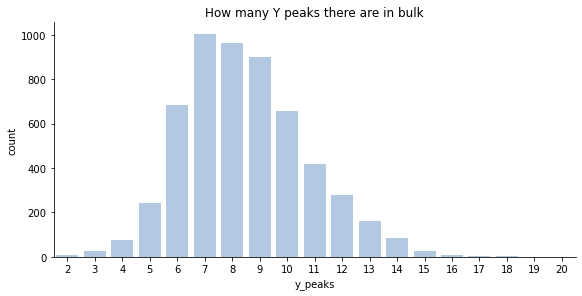

In [11]:
#How many y and b peaks are there on average?
plot = sns.catplot(x="y_peaks", color= '#abc9ea', hue=None,
                data=large, kind="count",
                height=4, aspect=2).set(title='How many Y peaks there are in bulk')

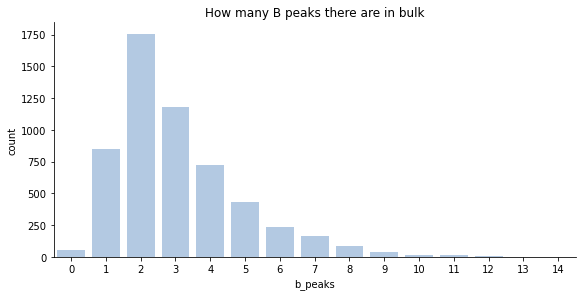

In [12]:
plot = sns.catplot(x="b_peaks", color= '#abc9ea', hue=None,
                data=large, kind="count",
                height=4, aspect=2).set(title='How many B peaks there are in bulk')

In [13]:
#for each protein count number of peaks for bulk and single cell, and get the difference

#give them the same index (index by peptide name)
new_small = small.set_index("peptide")
new_large = large.set_index("peptide")
both = pd.merge(left=new_small, right=new_large,suffixes=('_small', '_large'), left_index=True, right_index=True, how="outer")
# # small["Matched Ion Counts"]- large["Matched Ion Counts"]
both["diff_total"] = both["Matched Ion Counts_large"] - both["Matched Ion Counts_small"] 
both["diff_y"] = both["y_peaks_large"] - both["y_peaks_small"]
both["diff_b"] = both["b_peaks_large"] - both["b_peaks_small"]
####
#0 mean that they have the same number of peaks
# positive means that sc spectrum had more peaks
# negative means that bulk had more peaks

In [14]:
len(both)

5555

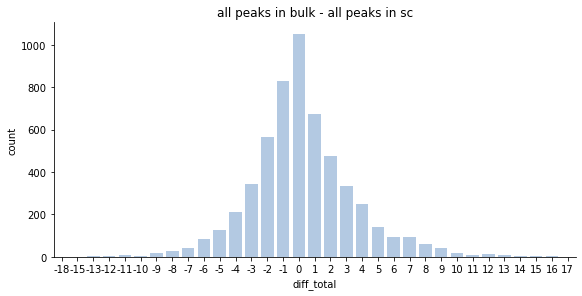

In [15]:
plot = sns.catplot(x="diff_total", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title='all peaks in bulk - all peaks in sc')

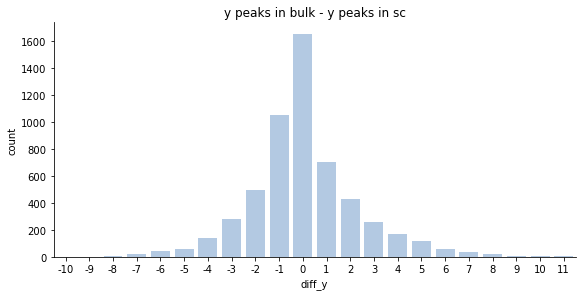

In [16]:
plot = sns.catplot(x="diff_y", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title="y peaks in bulk - y peaks in sc")

In [17]:
(len(both[both['diff_y']>=3]) *100)/len(both)

12.169216921692168

In [18]:
(len(both[both['diff_b']>=3]) *100)/len(both)

7.110711071107111

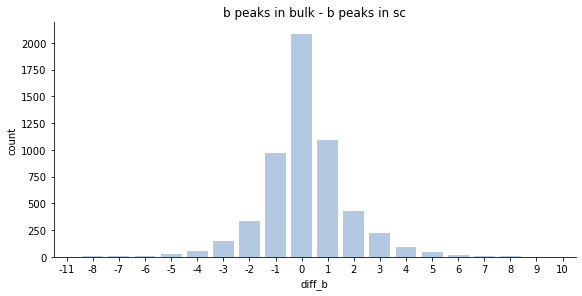

In [19]:
plot = sns.catplot(x="diff_b", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title="b peaks in bulk - b peaks in sc")

In [20]:
# get exmaple spectra
missing_1y = both[both['diff_y']==1]
missing_1y[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
AADALEEQQR,13554,17742
AADPPAENSSAPEAEQGGAE,14754,33659
AAELIANSLATAGDGLIELR,37759,89377
AAHSEGNTTAGLDM+15.995R,14765,12228
AAQDRDQIYR,12667,12415
...,...,...
YQQAGLPLIVLAGK,32736,78848
YRPGTVALR,15415,21547
YSDFEWLR,30647,68539


In [21]:
missing_4y = both[both['diff_y']==4]
missing_4y[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
AAAPAPEEEMDECEQALAAEPK,25480,60913
AAQLIGTCSQNVAAIQEQVLGLGALR,38709,91231
AASDIAMTELPPTHPIR,22357,53742
AAVENLPTFLVELSR,39832,91823
ACANPAAGSVILLENLR,33280,77325
...,...,...
YHTINGHNCEVK,10968,7601
YIMVPSGNMGVFDPTEIHNR,29781,73857
YLLSQSSPAPLTAAEEELR,31249,76336


In [22]:
import numbers
def get_intensities(row, small):
    intensities = []
    if small == True:
        line = row["Matched Ion Intensities_small"].split(";")
    else:
        line = row["Matched Ion Intensities_large"].split(";")
    for el in line:
        el = el.strip('][').split(",")
        for sub_el in el:
            sub_el = sub_el.split(":")[1]
            intensities.append(sub_el)
    return intensities

both["intensity_small"] = both.apply(lambda row: get_intensities(row, small=True), axis=1)
both["intensity_large"] = both.apply(lambda row: get_intensities(row, small=False), axis=1)

In [23]:
#get top 3 intensities
def get_top3(row, size, top):
    row['intensity_'+size].sort(key=int, reverse=True)
    if top==True:
        return3 = row['intensity_'+size][:3]
        return3 = [float(i) for i in return3]
    else:
        return3 = row['intensity_'+size][-3:]
        return3 = [float(i) for i in return3]
        
    return return3


both["top3_small"] = both.apply(lambda row: get_top3(row, size="small", top=True), axis=1)
both["bottom3_small"] = both.apply(lambda row: get_top3(row, size='small', top=False), axis=1)
both["top3_large"] = both.apply(lambda row: get_top3(row, size="large", top=True), axis=1)
both["bottom3_large"] = both.apply(lambda row: get_top3(row, size='large', top=False), axis=1)


In [24]:
def get_intensity_diff(row, size):
    intensity_diff = st.mean(row["top3_"+size])/st.mean(row["bottom3_"+size])
    return intensity_diff

both['intensity_diff_small'] = both.apply(lambda row: get_intensity_diff(row, size="small"), axis=1)
both['intensity_diff_large'] = both.apply(lambda row: get_intensity_diff(row, size="large"), axis=1)


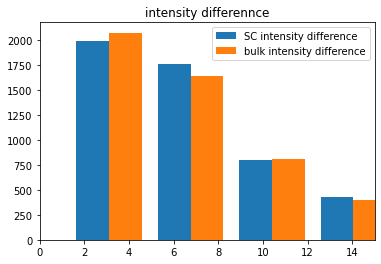

In [25]:
x = both["intensity_diff_small"]
y = both["intensity_diff_large"]
plt.hist([x, y], bins = 20)
plt.legend(['SC intensity difference', 'bulk intensity difference'])
plt.title("intensity differennce")
plt.xlim([0,15])
plt.show()

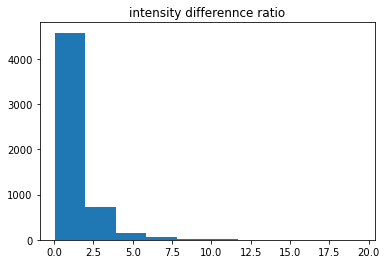

In [26]:
both["intensity_diff_ratio"] = both["intensity_diff_large"]/both["intensity_diff_small"]


plt.hist([both["intensity_diff_ratio"]])
plt.title("intensity differennce ratio")
plt.show()

In [27]:
both['intensity_diff_ratio']

peptide
AAAAAAAAAPAAAATAPTTAATTAATAAQ    1.503775
AAAAAAALQAK                      0.645296
AAAAADLANR                       1.171410
AAAEVNQDYGLDPK                   0.795051
AAAFEQLQK                        1.339527
                                   ...   
YYPTEDVPR                        0.560569
YYPTEDVPRK                       0.782096
YYTPTISR                         1.280410
YYTSASGDEMVSLK                   0.134647
YYVTIIDAPGHR                     1.279673
Name: intensity_diff_ratio, Length: 5555, dtype: float64

In [28]:
#example of 1:1 and 2:1

In [29]:
both[both.index == "LNWLSVDFNNWK"]

,decoy_small,scan_small,probability_small,Matched Ion Series_small,Matched Ion Intensities_small,Matched Ion Counts_small,Matched Ion Mass Diff (Ppm)_small,b_peaks_small,y_peaks_small,decoy_large,...,diff_b,intensity_small,intensity_large,top3_small,bottom3_small,top3_large,bottom3_large,intensity_diff_small,intensity_diff_large,intensity_diff_ratio
peptide,,,,,,,,,,,,,,,,,,,,,


In [30]:
one_to_one = both[(both["intensity_diff_ratio"] > 1) & (both["intensity_diff_ratio"] < 1.2)]
two_to_one = both[(both["intensity_diff_ratio"] > 2) & (both["intensity_diff_ratio"] < 2.5)]
three_to_one = both[(both["intensity_diff_ratio"] > 3) & (both["intensity_diff_ratio"] < 3.2)]
four_to_one = both[(both["intensity_diff_ratio"] > 4) & (both["intensity_diff_ratio"] < 4.5)]

In [31]:
one_to_one[["scan_small", "scan_large", "probability_small", "probability_large"]]

,scan_small,scan_large,probability_small,probability_large
peptide,,,,
AAAAADLANR,13639,19083,0.000006,0.000977
AAILPTSIFLTNK,33075,80487,0.000026,0.000098
AALAHSEEVTASQVAATK,17232,30157,0.000001,0.000019
AALEELVK,21939,44945,0.000019,0.000059
AAYLSDPR,16338,27082,0.000020,0.001265
...,...,...,...,...
YPVNSVNILK,23443,52488,0.000004,0.000020
YQLDPTASISAK,21619,50878,0.000005,0.000032
YQQGDFGYCPR,20095,38998,0.000012,0.000023


In [32]:
two_to_one[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
AADALEEQQR,13554,17742
ADATNVNNWHWTER,22488,44567
AEGLGDGYR,15941,23778
AGDMENAENILTVMR,31053,75093
AGEVFIHK,15245,19578
...,...,...
YIMVPSGNMGVFDPTEIHNR,29781,73857
YPALTKPENQDIDWTLLEGETR,30468,74496
YRDPTTVTTLR,17252,31093


In [33]:
three_to_one[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
ALLTPVAIAAGR,26795,65215
APVPASELLASGVLSR,30279,74687
AQLEPVASPAK,15768,30093
DAEDAMDAMDGAVLDGR,30115,79252
DLEAHIDSANK,15711,25794
EGGDGEEQDVGDAGR,12651,19337
EGIPALDNFLDKL,40702,99846
FCLGLLSNVNR,30621,71745
FGEVVDCTIK|FGEVVDCTIK|FGEVVDCTLK,21192,47667


In [34]:
four_to_one[["scan_small", "scan_large"]]

,scan_small,scan_large
peptide,,
AAQDRDQIYR,12667,12415
ADGGTQVIDTK,13875,22274
AENNSEVGASGYGVPGPTWDR,24412,59610
AEPPQAMNALMR,23171,51129
AQFEGIVTDLIR,34031,80205
DAVTYTEHAK,12487,14816
EHVIEALR,16451,24686
EIEDPEDR,13970,20427
GFGFITFTNPEHASVAMR,30828,71010


In [35]:
both[both['scan_small']=="35078"]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,decoy_small,scan_small,probability_small,Matched Ion Series_small,Matched Ion Intensities_small,Matched Ion Counts_small,Matched Ion Mass Diff (Ppm)_small,b_peaks_small,y_peaks_small,decoy_large,...,diff_b,intensity_small,intensity_large,top3_small,bottom3_small,top3_large,bottom3_large,intensity_diff_small,intensity_diff_large,intensity_diff_ratio
peptide,,,,,,,,,,,,,,,,,,,,,


In [36]:
def count_len(row):
    length = len(row["peptide"])
    return length

small["len"]= small.apply(lambda row: count_len(row), axis=1)
small_7to14 = small[(small['len'] >=7) & (small['len'] <=14)]
small_14to21 = small[(small['len'] >14) & (small['len'] <=21)]
small_21to44 = small[(small['len'] >21) & (small['len'] <=44)]

large["len"]= large.apply(lambda row: count_len(row), axis=1)
large_7to14 = large[(large['len'] >=7) & (large['len'] <=14)]
large_14to21 = large[(large['len'] >14) & (large['len'] <=21)]
large_21to44 = large[(large['len'] >21) & (large['len'] <=44)]

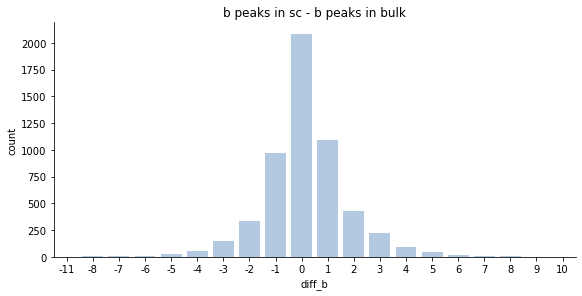

In [37]:
plot = sns.catplot(x="diff_b", color= '#abc9ea', hue=None,
                data=both, kind="count",
                height=4, aspect=2).set(title="b peaks in sc - b peaks in bulk")

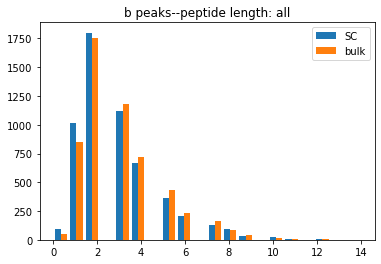

In [38]:
x = small["b_peaks"]
y = large["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: all")

plt.show()

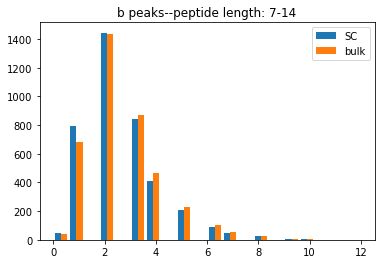

In [39]:
x = small_7to14["b_peaks"]
y = large_7to14["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: 7-14")
plt.show()

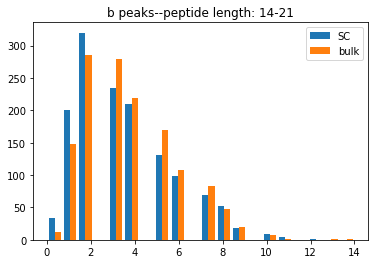

In [40]:
x = small_14to21["b_peaks"]
y = large_14to21["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: 14-21")
plt.show()

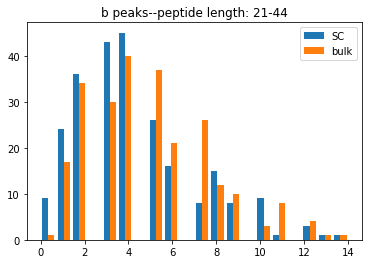

In [41]:
x = small_21to44["b_peaks"]
y = large_21to44["b_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("b peaks--peptide length: 21-44")
plt.show()

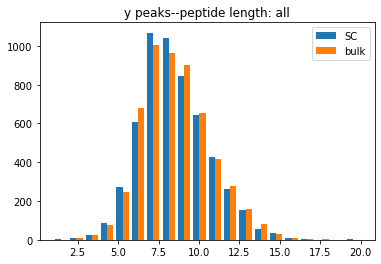

In [42]:
x = small["y_peaks"]
y = large["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: all")
plt.show()

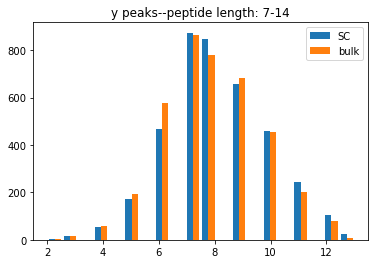

In [43]:
x = small_7to14["y_peaks"]
y = large_7to14["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: 7-14")
plt.show()

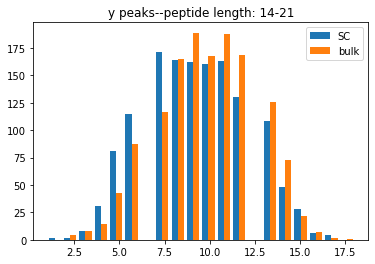

In [44]:
x = small_14to21["y_peaks"]
y = large_14to21["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: 14-21")
plt.show()

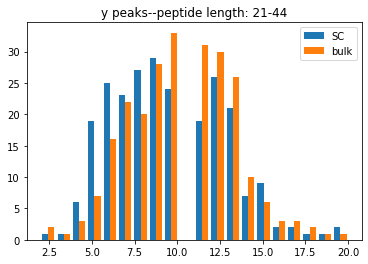

In [45]:
x = small_21to44["y_peaks"]
y = large_21to44["y_peaks"]
plt.hist([x, y], bins = 20)
plt.legend(['SC', 'bulk'])
plt.title("y peaks--peptide length: 21-44")
plt.show()

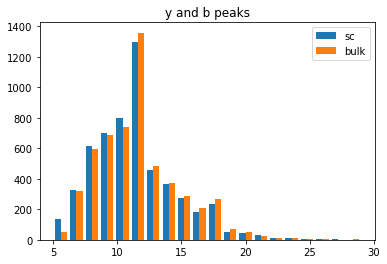

In [46]:
x = small["Matched Ion Counts"]
y = large["Matched Ion Counts"]
plt.hist([x, y], bins=20)
plt.legend(['sc', 'bulk'])
plt.title("y and b peaks")
plt.show()
